## Homework - Evaluation Metrics for Classification 

In this homework, we will use Credit Card Data from book "Econometric Analysis".

## Dataset

Here's a wget-able [link](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv):

```bash
wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv
```

The goal of this homework is to inspect the output of different evaluation metrics by creating a classification model (target column `card`). 

## Preparation

* Create the target variable by mapping `yes` to 1 and `no` to 0. 
* Split the dataset into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv('data/AER_credit_card_data.csv')
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [3]:
df.loc[:,'card'] = df['card'].replace(to_replace = ['yes','no'],value = [1,0])
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,1,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,1,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,1,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,1,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,1,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


We can now drop the 'card' column:

In [4]:
from sklearn.model_selection import train_test_split

#Create a train and a test set
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)

# Divide the test set into traind and validation
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

# Create the target arrays and remove the target columns from the train and validation datasets
y_train = df_train['card'].values
y_val = df_val['card'].values
y_test = df_test['card'].values

del df_train['card']
del df_val['card']
del df_test['card']

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the `card` variable.
* Use the training dataset for that.

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenditure']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `reports`
- `dependents`
- `active`
- `share`

In [5]:
from sklearn.metrics import roc_auc_score

features = ['reports',
            'dependents',
            'active',
            'share']

for feature in features:
    if roc_auc_score(y_train, df_train[feature]) < 0.5:
        print(feature, roc_auc_score(y_train, -df_train[feature]))
    else:
        print(feature, roc_auc_score(y_train, df_train[feature]))

reports 0.7166629860689376
dependents 0.5327757227773791
active 0.6043173411362006
share 0.989183643423692


A: The feature ```share``` has the highest AUC.

## Training the model

From now on, use these columns only:

```
["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```


## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.615
- 0.515
- 0.715
- 0.995

In [6]:
from sklearn.feature_extraction import DictVectorizer

columns = ["reports", 
           "age", 
           "income", 
           "share", 
           "expenditure", 
           "dependents", 
           "months", 
           "majorcards", 
           "active", 
           "owner", 
           "selfemp"]

train_dict = df_train[columns].to_dict(orient='records')
val_dict = df_val[columns].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

X_train = dv.transform(train_dict)
X_val = dv.transform(val_dict)

In [7]:
from sklearn.linear_model import LogisticRegression

model_lr = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

model_lr.fit(X_train, y_train)

pred_proba_lr = model_lr.predict_proba(X_val)[:,1]

score_lr = roc_auc_score(y_val, pred_proba_lr)

print("AUC: {:0.3f}".format(score_lr))

AUC: 0.995


## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them


At which threshold precision and recall curves intersect?

* 0.1
* 0.3
* 0.6
* 0.8

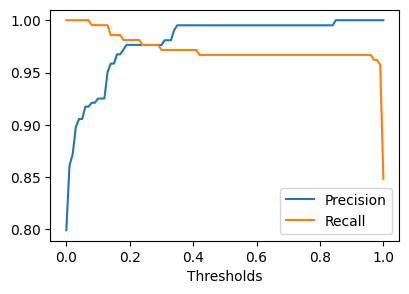

In [25]:
from cProfile import label
from sklearn.metrics import precision_score, recall_score

thresholds = np.arange(0, 1.01, 0.01)

precisions = []
recalls = []
for t in thresholds:
    card_pred = pred_proba_lr >= t
    precisions.append(precision_score(y_val, card_pred))
    recalls.append(recall_score(y_val, card_pred))

plt.figure(figsize=(4.5,3))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Thresholds')
plt.legend()
plt.show()

Both curves intersect at threshold = 0.3

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

F1 = 2 * P * R / (P + R)

Where P is precision and R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.1
- 0.4
- 0.6
- 0.7

## Question 5

Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


How large is standard devidation of the AUC scores across different folds?

- 0.003
- 0.014
- 0.09
- 0.24

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)


Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

## Submit the results

* Submit your results here: https://forms.gle/8TfKNRd5Jq7sGK5M9
* You can submit your solution multiple times. In this case, only the last submission will be used 
* If your answer doesn't match options exactly, select the closest one


## Deadline

The deadline for submitting is October 3 (Monday), 23:00 CEST.

After that, the form will be closed.